In [23]:
# imports
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import rcParams
from astropy.visualization import make_lupton_rgb

%matplotlib inline
rcParams['figure.figsize'] = [10, 8]

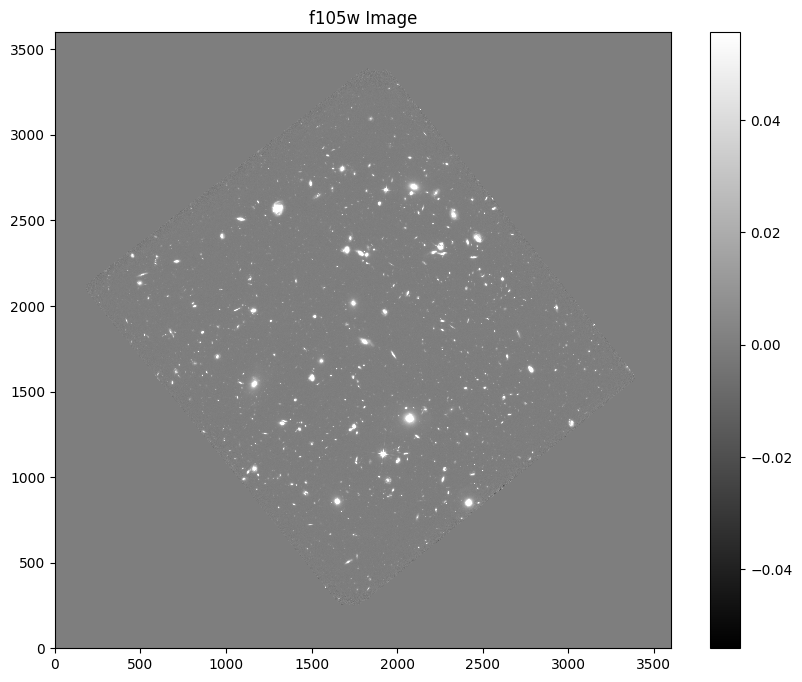

In [24]:
# give variables to the files
f105 = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
f125 = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
f160 = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

# read image with astropy
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits') as hdul:
    data = hdul[0].data.astype(np.float32)  

# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.title('f105w Image')
plt.savefig('udf_f105w_image.png', dpi=200)
plt.show()

In [25]:
bkg = sep.Background(data)

In [26]:
# print bkg data
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


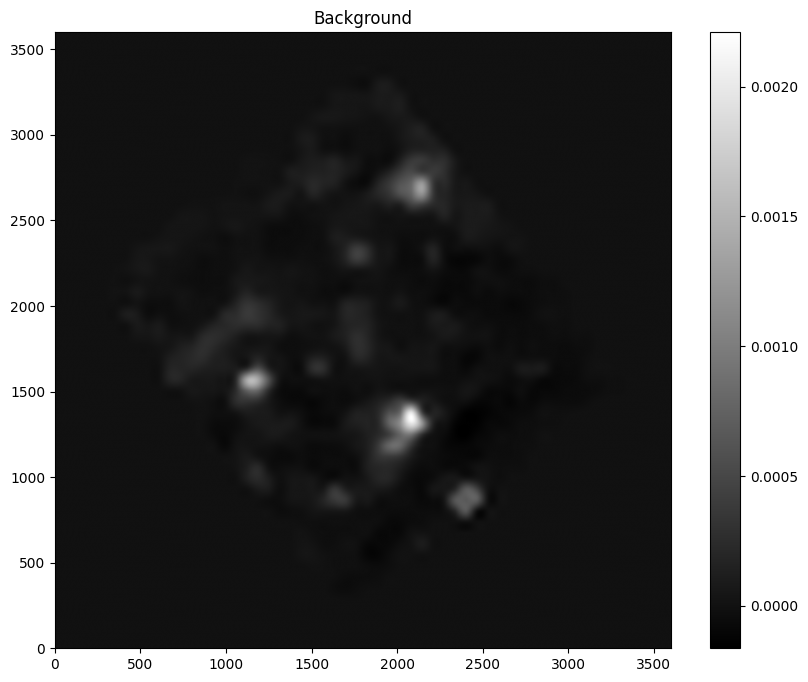

In [27]:
# show bkg color 
bkg_img = bkg.back()
plt.imshow(bkg_img, cmap='grey', origin='lower')
plt.colorbar()
plt.title('Background')
plt.savefig('udf_f105w_background.png', dpi=200)
plt.show()

In [28]:
bkg_rms = bkg.rms()

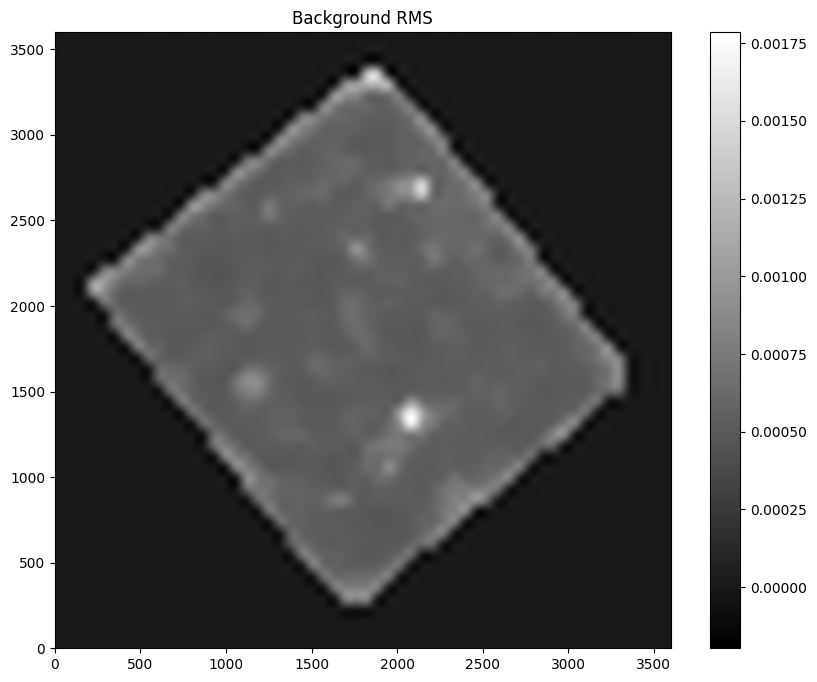

In [29]:
# show bkg rms color
plt.imshow(bkg_rms, cmap='grey', origin='lower')
plt.colorbar()
plt.title('Background RMS')
plt.savefig('udf_f105w_background_rms.png', dpi=200)
plt.show()

In [30]:
data_sub = data - bkg

In [31]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [32]:
# amt of objects identified
len(objects)

8630

In [ ]:
# place img on sub plot
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
ax.imshow(data_sub, cmap='grey', vmin=m-s, vmax=m+s, origin='lower')

# locate all objects
for i in range(len(objects)):
    e = Ellipse(
        xy=(objects['x'][i], objects['y'][i]),
        width=6 * objects['a'][i],
        height=6 * objects['b'][i],
        angle=objects['theta'][i] * 180 / np.pi
    )
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_patch(e)

plt.title('Detected Objects')
plt.savefig('udf_f105w_detected_objects.png', dpi=200)
plt.show()

In [ ]:
objects.dtype.names

In [ ]:
# measures fluxes of all detected objects
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0,err=bkg.globalrms, gain =1.0)

In [ ]:
# loop for first 10 objects
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

In [ ]:
# create histogram
plt.hist(flux, bins=100)
plt.xlabel('Flux')
plt.ylabel('Count')
plt.title('Flux Histogram (f105)')
plt.savefig('udf_f105w_flux_hist.png', dpi=200)
plt.show()

In [ ]:
# print and calculate mean, median, and std
print("Mean flux:", np.mean(flux))
print("Median flux:", np.median(flux))
print("Std flux:", np.std(flux))

In [ ]:
# locate pos of max flux
idx = np.argmax(flux)
max_flux = flux[idx]
xpos, ypos = objects['x'][idx], objects['y'][idx]

In [ ]:
# calculate sigma
sig = (max_flux - np.mean(flux)) / np.std(flux)

In [ ]:
# print brightness level of max flux, locate max flux, and print sigma
print('Brightest flux:', max_flux)
print('Location (x, y):', xpos, ypos)
print('Sigma above mean:', sig)

In [ ]:
# show the cutout of the max flux
cut = data[int(ypos-40):int(ypos+40), int(xpos-40):int(xpos+40)]
plt.imshow(cut, cmap='grey', origin='lower')
plt.title('Cutout of Brightest Source')
plt.colorbar()
plt.savefig('udf_f105w_max_outlier_cutout.png', dpi=200)
plt.show()

In [ ]:
# read image with astropy
with fits.open(f125) as hdul:
    img125 = hdul[0].data.astype(np.float32)
with fits.open(f160) as hdul:
    img160 = hdul[0].data.astype(np.float32)

In [ ]:
# overlap of f105, f125, f160
for arr in (data, img125, img160):
    arr[np.isnan(arr)] = 0
    arr[np.isinf(arr)] = 0

# add colors
rgb = make_lupton_rgb(img160, img125, data, Q=8, stretch=0.02)

# show the colored image
plt.figure(figsize=(10,10))
plt.imshow(rgb, origin='lower')
plt.axis('off')
plt.title('HUDF RGB Composite')
plt.savefig('udf_rgb_160_125_105.png', dpi=200, bbox_inches='tight')
plt.show()